# Getting started

This notebook is based on IBM Quantum's 'Quantum chemistry with VQE' course available here: https://quantum.cloud.ibm.com/learning/en/courses/quantum-chem-with-vqe

First we need to import `qiskit` and other required packages:
- `qiskit_aer` for classical simulation of the quantum hardware
- `qiskit_ibm_runtime` to access the primitives used to run the VQE
- `pyscf` to perform classical quantum chemistry calculations
- `matplotlib` and `pylatexenc` to draw circuits and plot results
- `numpy` (`np`) for general math capabilities including array operations

In [2]:
import qiskit
import qiskit_aer
import qiskit_ibm_runtime
import pyscf
import matplotlib
import pylatexenc
import numpy as np
print('qiskit            :', qiskit.__version__)
print('qiskit_aer        :', qiskit_aer.__version__)
print('qiskit_ibm_runtime:', qiskit_ibm_runtime.__version__)
print('pyscf             :', pyscf.__version__)
print('matplotlib        :', matplotlib.__version__)
print('pylatexenc        :', pylatexenc.__version__)
print('np                :', np.__version__)

qiskit            : 2.2.0
qiskit_aer        : 0.17.2
qiskit_ibm_runtime: 0.42.0
pyscf             : 2.10.0
matplotlib        : 3.10.6
pylatexenc        : 2.10
np                : 2.3.3


We can also print out the version we're using, don't worry if your version is not exactly the same, the code will *probably* still work...

For reference, I'm using python 3.13.1

# Defining molecules and building Hamiltonians

The simplest molecule is the hydrogen molecule, H$_2$. The molecule itself only depends on 1 variable, the `bond_distance` between the two hydrogen atoms, it's equilibrium value is about 0.735 Å, but you can set this to be whatever you like (within reason). However, our calculation needs a few other parameters such as the total spin, total charge and symmetry of the molecule, as well a choice of atomic orbital basis.

In [ ]:
from pyscf import gto

bond_distance = 
# in angstrom (Å)

atomic_position = bond_distance / 2
mol = gto.Mole()
mol.build(
    verbose=0,
    atom=[["H", (0, 0, -atomic_position)],
          ["H", (0, 0,  atomic_position)]],
    basis="sto-6g",
    spin=0,
    charge=0,
    symmetry="Dooh",
)

We now have a representation of the hydrogen molecule that we can perform computations on. The simplest computation we can perform is a 'mean-field' calculation, which we can do through the `scf` module

In [4]:
from pyscf import scf

# mf is short for mean-field calculation, a cheap calculation that gives us an approximate energy value
mf = scf.RHF(mol)
mf.scf()

print('Mean-field:')
print('Nuclear repulsion energy:', mf.energy_nuc())
print('Electronic energy       :', mf.energy_elec()[0])
print('Total energy            :', mf.energy_tot())
print('                         ', mf.energy_nuc() + mf.energy_elec()[0])

Mean-field:
Nuclear repulsion energy: 0.7199689944489797
Electronic energy       : -1.8455976628764188
Total energy            : -1.125628668427439
                          -1.125628668427439


This computes a rough approximation to the electronic energy which combines the effects of the electrons being attracted to the nuclei and repelled from each other. The nuclear repulsion energy can be calculated exactly, since we defined exactly where the nuclei (atoms) are. The total energy is the sum of the electronic and nuclear energies. We can confirm this ourselves.

We can also perform a more accuracte 'complete active space' calculation through the `mcscf` module

In [5]:
from pyscf import mcscf

# perform a complete active space calculation, this will serve as the "exact" answer we would like to achieve using VQE
molecular_orbitals = mf.mo_coeff
cas = mcscf.CASCI(mf, ncas=2, nelecas=(1, 1))
cas_results = cas.kernel(molecular_orbitals)
print('Complete active space:')
# nuclear repulsion energy doesn't change...
print('Nuclear repulsion energy:', mf.energy_nuc())
print('Electronic energy       :', cas_results[1])
print('Total energy            :', cas_results[0])
print('                         ', mf.energy_nuc() + cas_results[1])

Complete active space:
Nuclear repulsion energy: 0.7199689944489797
Electronic energy       : -1.8659468483033685
Total energy            : -1.1459778538543888
                          -1.1459778538543888


We can see that this gives us a lower energy than the less accurate mean-field approximation, this is due to the variational principle. We can also check that the total energy we obtain is still equal to the sum of the electronic and nuclear energies.

Notice that the mean-field and complete active space energy results are quite close together (or maybe not, depending on what bond length you chose). This indicates that the mean-field approximation is a good approximation to the true behaviour. For larger more complicated chemical systems, mean-field approximations are less accurate and high accuracy methods such as large complete active space calculations or full configuration interaction become very expensive. This is the regime where we want to use quantum computers to achieve a quantum advantage, but for today we're working with a simple problem as a proof-of-principle experiment.

To run VQE on our molecule we need to extract the Hamiltonian in a suitable form. This can be quite an involved process so there's no need to try to understand the code below

In [6]:
from qiskit.quantum_info import SparsePauliOp

def cholesky(V, eps):
    # see https://arxiv.org/pdf/1711.02242.pdf section B2
    # see https://arxiv.org/abs/1808.02625
    # see https://arxiv.org/abs/2104.08957
    no = V.shape[0]
    chmax, ng = 20 * no, 0
    W = V.reshape(no**2, no**2)
    L = np.zeros((no**2, chmax))
    Dmax = np.diagonal(W).copy()
    nu_max = np.argmax(Dmax)
    vmax = Dmax[nu_max]
    while vmax > eps:
        L[:, ng] = W[:, nu_max]
        if ng > 0:
            L[:, ng] -= np.dot(L[:, 0:ng], (L.T)[0:ng, nu_max])
        L[:, ng] /= np.sqrt(vmax)
        Dmax[: no**2] -= L[: no**2, ng] ** 2
        ng += 1
        nu_max = np.argmax(Dmax)
        vmax = Dmax[nu_max]
    L = L[:, :ng].reshape((no, no, ng))
    # print(
    #     "accuracy of Cholesky decomposition ",
    #     np.abs(np.einsum("prg,qsg->prqs", L, L) - V).max(),
    # )
    return L, ng

    
def identity(n):
    return SparsePauliOp.from_list([("I" * n, 1)])
 
 
def creators_destructors(n, mapping="jordan_wigner"):
    c_list = []
    if mapping == "jordan_wigner":
        for p in range(n):
            if p == 0:
                ell, r = "I" * (n - 1), ""
            elif p == n - 1:
                ell, r = "", "Z" * (n - 1)
            else:
                ell, r = "I" * (n - p - 1), "Z" * p
            cp = SparsePauliOp.from_list([(ell + "X" + r, 0.5), (ell + "Y" + r, 0.5j)])
            c_list.append(cp)
    else:
        raise ValueError("Unsupported mapping.")
    d_list = [cp.adjoint() for cp in c_list]
    return c_list, d_list


def build_hamiltonian(ecore: float, h1e: np.ndarray, h2e: np.ndarray) -> SparsePauliOp:
    ncas, _ = h1e.shape
 
    C, D = creators_destructors(2 * ncas, mapping="jordan_wigner")
    Exc = []
    for p in range(ncas):
        Excp = [C[p] @ D[p] + C[ncas + p] @ D[ncas + p]]
        for r in range(p + 1, ncas):
            Excp.append(
                C[p] @ D[r]
                + C[ncas + p] @ D[ncas + r]
                + C[r] @ D[p]
                + C[ncas + r] @ D[ncas + p]
            )
        Exc.append(Excp)
 
    # low-rank decomposition of the Hamiltonian
    Lop, ng = cholesky(h2e, 1e-6)
    t1e = h1e - 0.5 * np.einsum("pxxr->pr", h2e)
 
    H = ecore * identity(2 * ncas)
    # one-body term
    for p in range(ncas):
        for r in range(p, ncas):
            H += t1e[p, r] * Exc[p][r - p]
    # two-body term
    for g in range(ng):
        Lg = 0 * identity(2 * ncas)
        for p in range(ncas):
            for r in range(p, ncas):
                Lg += Lop[p, r, g] * Exc[p][r - p]
        H += 0.5 * Lg @ Lg
 
    return H.chop().simplify()

In [7]:
from pyscf import ao2mo
h1e, ecore = cas.get_h1eff()
h2e = ao2mo.restore(1, cas.get_h2eff(), cas.ncas)
H = build_hamiltonian(ecore, h1e, h2e)
print(H)

SparsePauliOp(['IIII', 'IIIZ', 'IZII', 'IIZI', 'ZIII', 'IZIZ', 'IIZZ', 'ZIIZ', 'IZZI', 'ZZII', 'ZIZI', 'YYYY', 'XXYY', 'YYXX', 'XXXX'],
              coeffs=[-0.09820182+0.j, -0.1740751 +0.j, -0.1740751 +0.j,  0.2242933 +0.j,
  0.2242933 +0.j,  0.16891402+0.j,  0.1210099 +0.j,  0.16631441+0.j,
  0.16631441+0.j,  0.1210099 +0.j,  0.17504456+0.j,  0.04530451+0.j,
  0.04530451+0.j,  0.04530451+0.j,  0.04530451+0.j])


This is the Hamiltonian of the hydrogen molecule in Pauli form and is now ready for us to perform VQE on. Note that this Hamiltonain *includes* the nuclear repulsion energy, which we will need to keep in mind when comparing results later. Check that you understand what the above output means, though you don't need to know how we obtained it.

# Generating an Ansatz

Choosing a good Ansatz for your VQE experiment is incredibly important, some things that make a good Ansatz are:
- Can produce states that are very close to the true ground-state
- Respects the capabilities of your quantum device

Some things that make a poor Ansatz are:
- Many parameters to optimise
- Deep circuits that accumulate more error

There is a library of Ansätze inbuilt into `qiskit`, let's take a look at the `efficient_su2` and `n_local` Ansätze. For each of them, try out the different options to see what they do. Keep in mind the criteria for a good Ansatz, are any of these choices of options likely to give particularly good/bad Ansätze?

### `efficient_su2` Ansatz

The `efficient_su2` Ansatz is composed of layers of single qubit (SU(2)) gates and entangling gates. Experiment with the code below to try out different options.

In [ ]:
from qiskit.circuit.library import efficient_su2
n_qubits = 4

reps = 2
insert_barriers = True
# entanglement = 'linear'
# entanglement = 'circular'
# entanglement = 'full'
# entanglement = 'pairwise'
# entanglement = 'reverse_linear'
# su2_gates = ['rx']
# su2_gates = ['rz']
# su2_gates = ['h']
# su2_gates = ['rx', 'h']

ansatz = efficient_su2(n_qubits, su2_gates, entanglement, reps=reps, insert_barriers=insert_barriers)
ansatz.draw('mpl')


Barriers are useful for visualisation and controlling precise timing of gates, but generally not necessary. Make sure to turn them off (`insert_barriers=False`) when it comes time to transpile the circuit.

### `n_local` Ansatz

The `n_local` Ansatz is a more general case of `efficient_su2` that allows us to use more complex structures in the entangling and rotation layers.

In [ ]:
from qiskit.circuit.library import n_local
n_qubits = 4

reps = 2
insert_barriers = False
# entanglement = 'linear'
# entanglement = 'circular'
# entanglement = 'pairwise'
# entanglement_blocks = ['cx']
# entanglement_blocks = ['cz']
# entanglement_blocks = ['crx']
# entanglement_blocks = ['ccx']
# rotation_blocks = ['rx']
# rotation_blocks = ['rx', 'h']
# rotation_blocks = ['crx']

ansatz = n_local(n_qubits, rotation_blocks, entanglement_blocks, entanglement, reps=reps, insert_barriers=insert_barriers)
# ansatz = ansatz.decompose()
ansatz.draw('mpl')


For more complicated sets of gates e.g. `'crx'` and `'ccx'`, the circuit will need to be decomposed in order to get an idea of its actual depth.

### Custom Ansätze

You can also construct your own ansätze by simply creating a circuit like below

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

n_qubits = 4
n_parameters = 8

theta = ParameterVector(r"$\Theta$", n_parameters)
ansatz = QuantumCircuit(n_qubits)

ansatz.rx(theta[0], 0)
ansatz.rx(theta[1], 1)
ansatz.rx(theta[2], 2)
ansatz.rx(theta[3], 3)

for i in range(1, n_qubits):
    ansatz.cz(0, i)
ansatz.rx(theta[4], 0)
for i in reversed(range(1, n_qubits)):
    ansatz.cz(0, i)
    
ansatz.rx(-theta[0], 0)
ansatz.rx(-theta[1], 1)
ansatz.rx(-theta[2], 2)
ansatz.rx(-theta[3], 3)

ansatz.draw('mpl')

In [ ]:
# Create your own Ansatz here!



# Classical optimisation

The `scipy` package has a variety of inbuilt optimisation routines including `'cobyla'`, `'slsqp'` and `'nelder-mead'`

In [ ]:
from scipy.optimize import minimize
# optimization_method = 'cobyla'
# optimization_method = 'slsqp'
# optimization_method = 'nelder-mead'

The cost function we wish to minimise is defined as:

In [10]:
def cost_func(parameters, ansatz_circuit, hamiltonian, estimator, path):
    pub = (ansatz_circuit, [hamiltonian], [parameters])
    # pub stands for Primitive Unified Bloc. It just holds the circuit, observable (Hamiltonian) and parameters
    result = estimator.run(pubs=[pub]).result()
    # run the estimator and retrieve the results
    energy = result[0].data.evs[0]
    path.append(energy)
    return energy

it takes a set of parameters and outputs the corresponding energy. To do so, it also requires knowledge of the Ansatz circuit, the Hamiltonian and an `Estimator` object. I've also added a `path` argument which we can use to record all the energies calculated and (hopefully) get a nice plot later. We also need to choose a set of parameters from which to start the minimisation, here we just pick random rotation angles between $0$ and $2\pi$

In [11]:
initial_parameters = 2 * np.pi * np.random.random(ansatz.num_parameters)
print(initial_parameters)

[4.21751693 6.20096843 6.11369465 1.56736532 1.38407173 1.88714499
 1.03805948 0.37073325 4.86415952 4.26259294 6.05261359 2.99426719]


# Running a VQE calculation

Following Qiskit patterns there are four steps to solving the problem:
1. Map classical inputs to a quantum problem
2. Optimize problem for quantum execution
3. Execute using Qiskit Primitives
4. Post-process and return result in classical format

## Step 1: map classical input to quantum problem

This mapping is performed by the definitions of the Hamiltonian and Ansatz. Let's check which ones we are using:

In [12]:
print(H)

SparsePauliOp(['IIII', 'IIIZ', 'IZII', 'IIZI', 'ZIII', 'IZIZ', 'IIZZ', 'ZIIZ', 'IZZI', 'ZZII', 'ZIZI', 'YYYY', 'XXYY', 'YYXX', 'XXXX'],
              coeffs=[-0.09820182+0.j, -0.1740751 +0.j, -0.1740751 +0.j,  0.2242933 +0.j,
  0.2242933 +0.j,  0.16891402+0.j,  0.1210099 +0.j,  0.16631441+0.j,
  0.16631441+0.j,  0.1210099 +0.j,  0.17504456+0.j,  0.04530451+0.j,
  0.04530451+0.j,  0.04530451+0.j,  0.04530451+0.j])


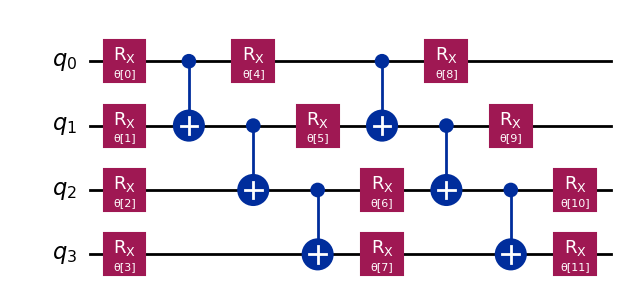

In [13]:
ansatz.draw('mpl')

## Step 2: optimize for quantum execution

To begin optimising the circuit, we need to select a backend. To access a real IBM quantum backend we can use:

In [14]:
from qiskit_ibm_runtime import QiskitRuntimeService
instance = 
token = 
service = QiskitRuntimeService(channel="ibm_cloud", instance=instance, token=token)
hardware_backend = service.least_busy(operational=True)
print('The least busy backend is:', hardware_backend.name)

## We can also select a specific backend by e.g.
# hardware_backend = service.backend(name = 'ibm_kingston')
# print('The selected backend is:', hardware_backend.name)
## or print all available backends with
# print('A list of all backends is:', service.backends())

qiskit_runtime_service._discover_account:WARNING:2025-10-01 11:35:03,464: Loading account with the given token. A saved account will not be used.


The least busy backend is: ibm_pittsburgh


you will need to insert your own `instance` and `token` values in order to log in through your account, or update the code to load your saved account from workshop 1. If we don't want to run on real hardware we can also use a noisy simulation based on the properties of the hardware:

In [15]:
from qiskit_aer import AerSimulator
noisy_simulator = AerSimulator.from_backend(hardware_backend)
print('The noisy simulator is:', noisy_simulator.name)

The noisy simulator is: aer_simulator_from(ibm_pittsburgh)


The circuit transpilation (optimisation of the circuit structure, not to be confused with optimisation of the circuit parameters) is performed by a series of passes controlled by a `PassManager`

In [ ]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes import ALAPScheduleAnalysis,PadDynamicalDecoupling,ConstrainedReschedule
from qiskit.circuit.library import XGate

# We can use either hardware_backend or noisy_simulator as the target here
target = noisy_simulator.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        ConstrainedReschedule(
            acquire_alignment=target.acquire_alignment,
            pulse_alignment=target.pulse_alignment,
            target=target),
        PadDynamicalDecoupling(
            target=target,
            dd_sequence=[XGate(), XGate()],
            pulse_alignment=target.pulse_alignment),
    ])
# The individual passes are
#     ALAPSSheduleAnalysis: schedules gates as late as possible.
#     ConstrainedReshedule: fixes alignment of gates (i.e. there's a minimum time-resolution that the backend can work with accurately)
#     PadDynamicalDecoupling: adds dynamical decoupling pulses to the qubit idle times

# Use the pass manager and draw the resulting circuit
transpiled_ansatz = pm.run(ansatz)
transpiled_ansatz.draw(output="mpl", idle_wires=False)

The circuit is probably longer than it was before transpilation. Can you say why?

Note that the transpiler has also mapped our original 4 'virtual' qubits to actual physical qubits on the device. We also need to tell the Hamiltonian which physical qubits to measure.

In [ ]:
transpiled_H = H.apply_layout(transpiled_ansatz.layout)
print(transpiled_H)

Do you understand why the Hamiltonian looks like this now?

## Step 3: execute with `qiskit` primitives

To execute on either quantum hardware or the simulator we can use the form below, simply replacing the `backend` argument of the `Session`. A session works works a little like a reservation of the device, once the session reaches the front of the queue, jobs submitted within the session have priority and don't need to wait in the queue. This is very useful for VQE and similar workflows where the next circuit depends on the results of the previous one. Since access to the hardware is limited (and we would need to wait in a queue to run our circuits), let's focus on the simulator first.

In [19]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime.options import EstimatorOptions
from qiskit_ibm_runtime import EstimatorV2 as Estimator

estimator_options = EstimatorOptions(resilience_level=0, default_shots=2000)
path = []
with Session(backend=noisy_simulator) as session:
    estimator = Estimator(mode=session, options=estimator_options)
    
    res = minimize(
        cost_func,
        initial_parameters,
        args=(transpiled_ansatz, transpiled_H, estimator, path),
        method="cobyla",
        options={"maxiter": 30, "disp": True},
    )

print('Nuclear repulsion energy:', mf.energy_nuc())
print('Electronic energy       :', res.fun-mf.energy_nuc())
print('Total energy            :', res.fun)

/Users/jonesm3/Python/virtualenvironment2/lib/python3.13/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Return from COBYLA because the objective function has been evaluated MAXFUN times.
Number of function values = 30   Least value of F = -0.5682256217676477
The corresponding X is:
[ 6.04141796  7.77214441  6.47924422  3.40446138  0.71183158  1.30034675
  1.33461145 -0.46682254  5.75749839  2.2508843   5.30040193  1.72372748]

Nuclear repulsion energy: 0.7199689944489797
Electronic energy       : -1.2881946162166273
Total energy            : -0.5682256217676477


## Step 4: post-process and return classical result

Most of the classical computation is handled by the `Estimator` primitive, but we can plot the results below

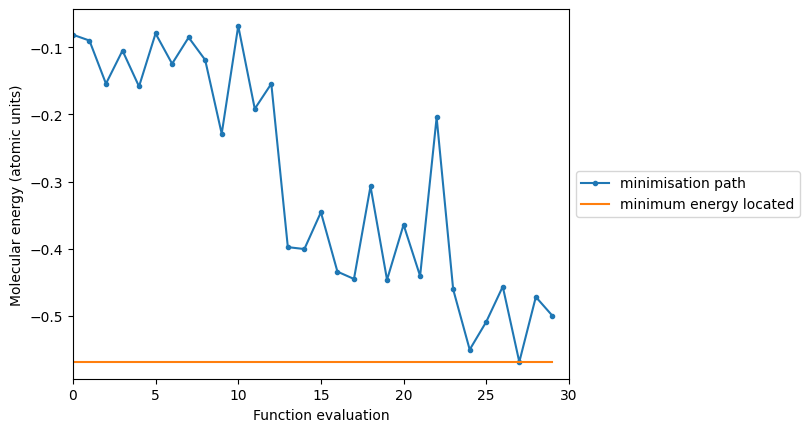

In [20]:
from matplotlib import pyplot as plt
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(range(res.nfev), path, '.-', label='minimisation path')
ax.plot([0,res.nfev-1], [res.fun]*2, label='minimum energy located')
# ax.plot([0,res.nfev-1], [mf.energy_tot()]*2, 'k:', label='MF energy')
# ax.plot([0,res.nfev-1], [cas_results[0]]*2, 'k--', label='CAS energy')
ax.set_ylabel('Molecular energy (atomic units)')
ax.set_xlabel('Function evaluation')
ax.set_xlim([0,res.nfev])
ax.legend(loc='center left', bbox_to_anchor=[1,0.5])

Do you understand the graph?

Add in the mean-field and complete active space results, what do you notice? What does this mean for your VQE results?

Test out different options:
- different Ansätze
- different initial parameters
- change the transpiler options
- use a different optimiser
- anything else you can think of

How do these affect your results? How would you improve the VQE results?